<a href="https://colab.research.google.com/github/Ludvins/VC/blob/master/Practica%202/Cifar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [0]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import keras.utils as np_utils
# Import optimizer
from keras.optimizers import SGD
# Import data
from keras.datasets import cifar100
# Import models and layers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Activation, BatchNormalization, Conv1D
# Import image proprocessors
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
# Import Resnet
from keras.applications.resnet50 import ResNet50, preprocess_input
# Import Early Stopping
from keras.callbacks import EarlyStopping
# Show no TensorFlow deprecation warnings
import tensorflow.compat.v1 as tf
tf.logging.set_verbosity(tf.logging.ERROR)

In [74]:
# Drive mount
path = "/content/drive/My Drive/VC/"
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
def prepare_files():
  !rm -rf "/content/drive/My Drive/VC/images"
  !rm -rf "/content/drive/My Drive/VC/lists"
  !unzip -q "/content/drive/My Drive/VC/Caltech" -d "/content/drive/My Drive/VC"

In [0]:
prepare_files()

## Auxiliar functions

Loads Cifar data.

In [0]:
def load_cifar_data():
    # Load Data
    (x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

    # Transform to float and normalize
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    
    # We will use only 25 classes.
    train_idx = np.isin(y_train, np.arange(25))
    train_idx = np.reshape(train_idx, -1)
    x_train = x_train[train_idx]
    y_train = y_train[train_idx]
    test_idx = np.isin(y_test, np.arange(25))
    test_idx = np.reshape(test_idx, -1)
    x_test = x_test[test_idx]
    y_test = y_test[test_idx]
    
    # Set labels to cathegorical
    y_train = np_utils.to_categorical(y_train, 25)
    y_test = np_utils.to_categorical(y_test, 25)
    
    return x_train, y_train, x_test, y_test

Returns images and classes in `relative_path`.







In [0]:
def read_img (relative_path):
    classes = np.array([im.split('/')[0] for im in relative_path])
    vim = np.array([img_to_array(load_img(path + "images/"+ im, target_size = (224,224,3))) 
                    for im in relative_path])

    return vim, classes

Reads `Caltech` data in `x_train`, `y_train`, `x_test` y `y_test`

In [0]:
def load_caltech_data():

    # Load files with paths
    train_path = np.loadtxt(path + "lists/train.txt", dtype = str)
    test_path = np.loadtxt(path + "lists/test.txt", dtype = str)

    # Read imgs
    print("Loading data...")
    x_train, y_train = read_img(train_path)
    x_test, y_test = read_img(test_path)
    print("Data loaded.")

    # Set classes to numerical
    unique_classes = np.unique(np.copy(y_train))
    for i in range(len(unique_classes)):
      y_train[y_train == unique_classes[i]] = i
      y_test[y_test == unique_classes[i]] = i

    # Set classes to categorical
    y_train = np_utils.to_categorical(y_train, 200)
    y_test = np_utils.to_categorical(y_test, 200)

    # Shuffle data
    x_train_perm = np.random.permutation(len(x_train))
    x_train = x_train[x_train_perm]
    y_train = y_train[x_train_perm]

    x_test_perm = np.random.permutation(len(x_test))
    x_test = x_test[x_test_perm]
    y_test = y_test[x_test_perm]

    # Preprocess data using Resnet function.
    x_train = preprocess_input(x_train)
    x_test = preprocess_input(x_test)

    return x_train, y_train, x_test, y_test

Shows model results in test partition.

In [0]:
def evaluate(model, x_test, y_test, verbose = 0):
    score = model.evaluate(x_test, y_test, verbose=verbose)
    print('PÉRDIDA: ', score[0])
    print('PRECISIÓN: ', score[1])

Draws two graphics.
+ Loss function evolution.
+ Accuracy function evolution.

Args:
+ ```hist```: Training records

In [0]:
def show_evolution(hist):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training loss', 'Validation loss'])
    plt.show()
    
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training accuracy', 'Validation accuracy'])
    plt.show()

Draws the same graphics as ```show_evolution``` but using a list of records ```hist```.

In [0]:
def compare_evolution(hist, names):

    for i in hist:
        val_loss = i.history['val_loss']
        plt.plot(val_loss)

    plt.legend(["Validation loss " + names[i] for i in range(len(hist))])
    plt.show()

    for i in hist:
        val_acc = i.history['val_acc']
        plt.plot(val_acc)

    plt.legend(["Validation accuracy " + names[i] for i in range(len(hist))])
    plt.show()

## Data generators

In [0]:
def basic_data_generator():
    return ImageDataGenerator(
        validation_split = 0.1)

In [0]:
def complex_data_generator():
  return ImageDataGenerator(
      featurewise_center = True,             # set input mean to 0 over the dataset
      samplewise_center = False,             # set each sample mean to 0
      featurewise_std_normalization = True,  # divide inputs by std of the dataset
      samplewise_std_normalization = False,  # divide each input by its std
      zca_whitening = False,                 # apply ZCA whitening
      zca_epsilon = 1e-06,                   # epsilon for ZCA whitening
      rotation_range = 0,                    # randomly rotate images in the range (degrees, 0 to 180)
      width_shift_range = 0.1,               # randomly shift images horizontally (fraction of total width)
      height_shift_range = 0.1,              # randomly shift images vertically (fraction of total height)
      shear_range = 0.,                      # set range for random shear
      zoom_range = 0.,                       # set range for random zoom
      channel_shift_range = 0.,              # set range for random channel shifts
      fill_mode = 'nearest',                 # set mode for filling points outside the input boundaries
      cval = 0.,                             # value used for fill_mode = "constant"
      horizontal_flip = True,                # randomly flip images
      vertical_flip = False,                 # randomly flip images
      rescale = None,                        # set rescaling factor (applied before any other transformation)
      preprocessing_function = None,         # set function that will be applied on each input
      data_format = None,                    # image data format, either "channels_first" or "channels_last"
      validation_split = 0.1)                # fraction of images reserved for validation (strictly between 0 and 1)

## Model definitions

In [0]:
def simple_base_net_model():
    model = Sequential()
    model.name = "Modelo BaseNet"
    model.add(Conv2D(6, kernel_size=(5, 5),
                     activation='relu',
                     input_shape=(32,32,3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, kernel_size=(5,5), 
                    activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(25, activation='softmax'))
    
    return model

In [0]:
def complex_base_net_model_no_norm():
    model = Sequential()
    model.name = "Modelo BaseNet sin BatchNormalization"
    model.add(Conv2D(32, (3, 3), padding='same', activation = 'relu', input_shape=(32,32,3)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(25, activation='softmax'))

    return model

In [0]:
def complex_base_net_model_norm_after_relu():
    model = Sequential()
    model.name = "Modelo BaseNet con BatchNormalization despues de Activacion"
    model.add(Conv2D(32, (3, 3), padding='same', activation = 'relu', input_shape=(32,32,3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(25, activation='softmax'))

    return model

In [0]:
def complex_base_net_model_norm_before_relu():
    model = Sequential()
    model.name = "Modelo BaseNet con BatchNormalization antes de Activacion"
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32,32,3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(25, activation='softmax'))

    return model

In [0]:
def basic_res_net(freeze = True):
      base_model = ResNet50(weights='imagenet', include_top=False, pooling="avg", input_shape=(224,224,3))
      if (freeze):
        for layer in base_model.layers:
          layer.trainable = False

      model = Sequential()
      model.name = "ResNet Original"
      model.add(base_model)
      model.add(Dense(200,
                    activation = 'softmax'))
      
      return model

In [0]:
def modified_res_net_model(freeze = True):

    base_model = ResNet50(weights='imagenet', include_top=False, pooling="avg", input_shape=(224,224,3))
    if (freeze):
      for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.name = "ResNet Modificado"
    model.add(base_model)
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(200,
                    activation = 'softmax'))

    return model

## Train function

In [0]:
def train_and_evaluate(model, data_generator, batch_size, load_data_function = load_cifar_data, epochs = 100, verbose = 0):

    if (verbose != 0):
      print(" - ENTRENAMIENTO - ")

    model.compile(
        loss = keras.losses.categorical_crossentropy,
        optimizer = SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True),
        metrics = ['accuracy']
    )

    x_train, y_train, x_test, y_test = load_data_function()
    datagen = data_generator()
    datagen.fit(x_train)
    datagen.standardize(x_test)

    h = model.fit_generator(
                generator = datagen.flow(x_train, y_train, batch_size, subset='training'),
                steps_per_epoch = len(x_train)*0.9/batch_size,
                epochs = epochs,
                validation_data = datagen.flow(x_train, y_train, batch_size, subset='validation'),
                validation_steps = len(x_train)*0.1/batch_size,
                verbose = verbose,
                callbacks = [EarlyStopping(monitor = 'val_acc', patience = 10, restore_best_weights = True)]
                )
    if (verbose != 0):
      print(" - RESULTADOS - ")

    evaluate(model, x_test, y_test)
    return h

# Main functions

--- APARTADO 1. ---
Model: "BaseNet Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 28, 28, 6)         456       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 50)                20050     
_________________________________________________________________
dense_16 (Dense)             (Non

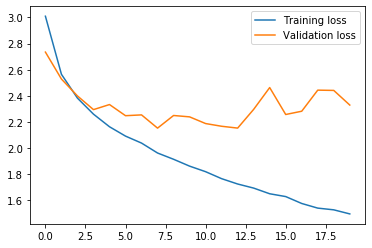

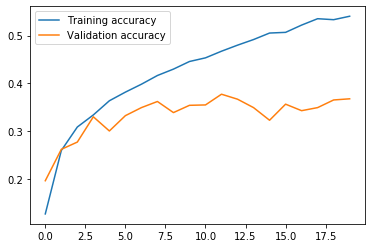

In [32]:
print("--- APARTADO 1. ---")
m1 = simple_base_net_model()
m1.summary()
h1 = train_and_evaluate(m1, basic_data_generator, 32, epochs = 20, verbose = 1)
print(" - GRÁFICAS - ")
show_evolution(h1)

--- COMPARACIÓN DE GENERADORES ---
 - RESULTADOS - 
PÉRDIDA:  1.8979652627944947
PRECISIÓN:  0.446
 - GRÁFICAS DE RESULTADOS -


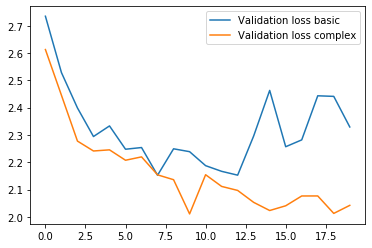

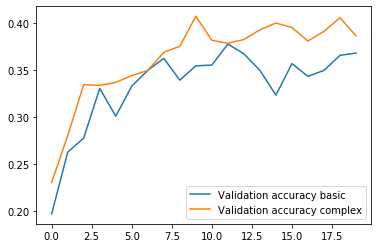

In [33]:
print("--- COMPARACIÓN DE GENERADORES ---")
h2 = train_and_evaluate(simple_base_net_model(), complex_data_generator, 32, epochs = 20)
print(" - GRÁFICAS DE RESULTADOS -")
compare_evolution([h1, h2], ["basic", "complex"])

 --- BASENET MODIFICADO SIN BATCHNORMALIZATION ---
Model: "Modelo BaseNet sin BatchNormalization"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 13, 13, 64)        36928     
____________________________________________

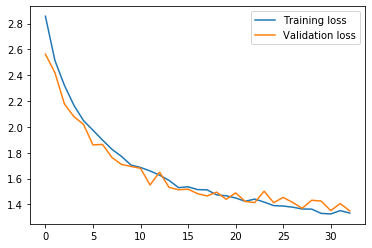

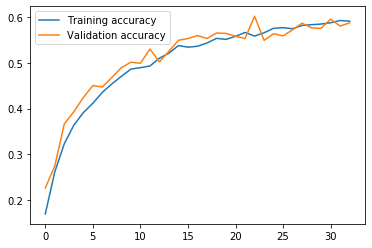

In [56]:
print(" --- BASENET MODIFICADO SIN BATCHNORMALIZATION ---")
m3 = complex_base_net_model_no_norm()
m3.summary()
h3 = train_and_evaluate(m3, complex_data_generator, 32)
print(" - GRÁFICAS DE RESULTADOS - ")
show_evolution(h3)

 --- BASENET MODIFICADO CON BATCHNORMALIZATION ANTES VS DESPUES --- 
 -- BATCHNORMALIZATION ANTES -- 
PÉRDIDA:  1.0646246698379516
PRECISIÓN:  0.6736
 - GRÁFICAS RESULTADOS - 


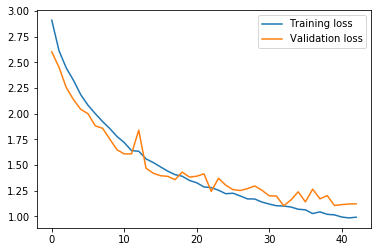

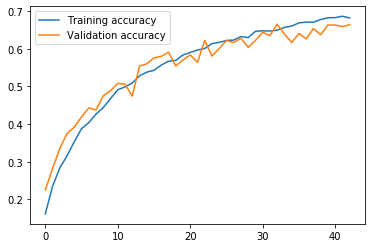

 -- BATCHNORMALIZATION DESPUÉS -- 
PÉRDIDA:  0.9629200864315033
PRECISIÓN:  0.7076
 - GRÁFICAS RESULTADOS - 


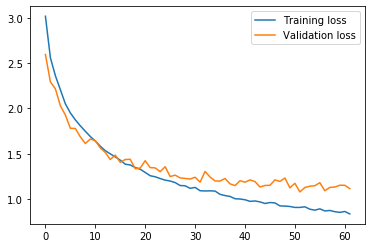

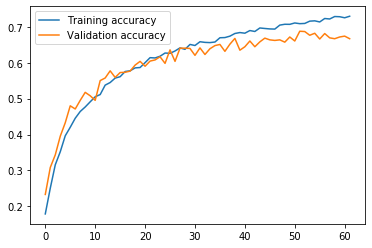

 - GRÁFICAS CONJUNTAS - 


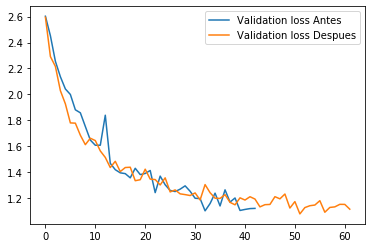

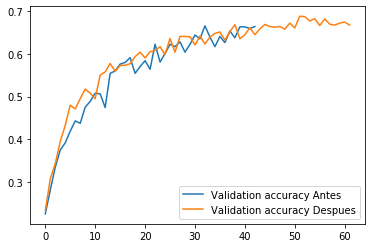

In [60]:
print(" --- BASENET MODIFICADO CON BATCHNORMALIZATION ANTES VS DESPUES --- ")
print(" -- BATCHNORMALIZATION ANTES -- ")
m3 = complex_base_net_model_norm_before_relu()
h3 = train_and_evaluate(m3, complex_data_generator, 32, verbose = 0)
print(" - GRÁFICAS RESULTADOS - ")
show_evolution(h3)

print(" -- BATCHNORMALIZATION DESPUÉS -- ")
m4 = complex_base_net_model_norm_after_relu()
h4 = train_and_evaluate(m4, complex_data_generator, 32, verbose = 0)
print(" - GRÁFICAS RESULTADOS - ")
show_evolution(h4)

print(" - GRÁFICAS CONJUNTAS - ")
compare_evolution([h3, h4], ["Antes", "Despues"])

 --- RESNET SIN MODIFICAR --- 
94658560/94653016 [==============================] - 1s 0us/step
Model: "ResNet Original"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_19 (Dense)             (None, 200)               409800    
Total params: 23,997,512
Trainable params: 409,800
Non-trainable params: 23,587,712
_________________________________________________________________
 - ENTRENAMIENTO - 
Loading data...
Data loaded.
Epoch 1/10
85/84 [==============================] - 13s 155ms/step - loss: 4.7265 - acc: 0.0816 - val_loss: 3.7304 - val_acc: 0.2133
Epoch 2/10
85/84 [==============================] - 6s 76ms/step - loss: 2.1727 - acc: 0.5318 - val_loss: 3.1388 - val_acc: 0.2667
Epoch 3/10
85/84 [==============================] - 7s 77ms/step - loss: 1.1557 - acc:

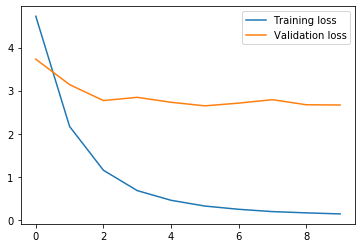

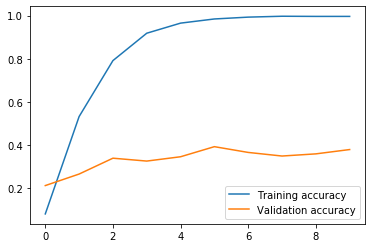

In [61]:
print(" --- RESNET SIN MODIFICAR --- ")
m5 = basic_res_net(True)
m5.summary()
h5 = train_and_evaluate(m5, basic_data_generator, 32, load_caltech_data, epochs = 10, verbose = 1)
print(" - GRÁFICAS - ")
show_evolution(h5)

 --- RESNET MODIFICADO PRIMERAS CAPAS CONGELADAS ----
Model: "ResNet Modificado"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dropout_28 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               1049088   
_________________________________________________________________
activation_119 (Activation)  (None, 512)               0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 200)               102600    
Total params: 24,739,400
Trainable params: 1,151,688
Non-trai

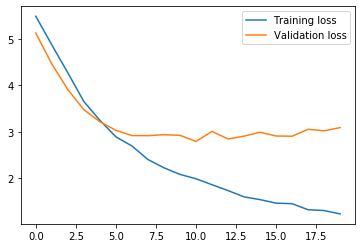

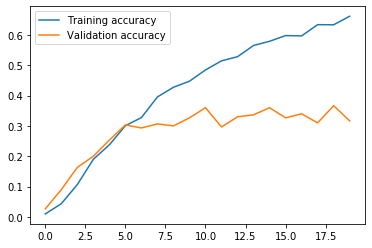

In [62]:
print(" --- RESNET MODIFICADO PRIMERAS CAPAS CONGELADAS ----")
m6 = modified_res_net_model()
m6.summary()
h6 = train_and_evaluate(m6, basic_data_generator, 32, load_caltech_data, epochs = 20, verbose = 1)
print(" - GRÁFICAS - ")
show_evolution(h6)

 --- RESNET MODIFICADO SIN CONGELAR --- 
Model: "ResNet Modificado"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dropout_34 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 512)               1049088   
_________________________________________________________________
activation_367 (Activation)  (None, 512)               0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 200)               102600    
Total params: 24,739,400
Trainable params: 24,686,280
Non-trainable params

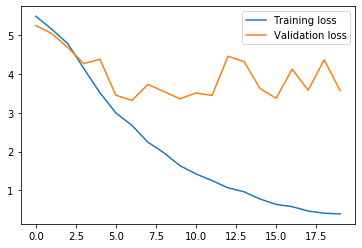

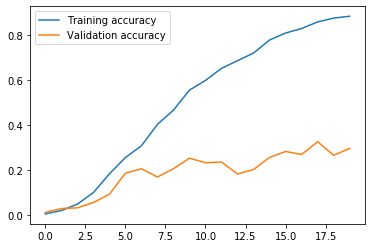

In [93]:
print(" --- RESNET MODIFICADO SIN CONGELAR --- ")
m7 = modified_res_net_model(freeze = False)
m7.summary()
h7 = train_and_evaluate(m7, basic_data_generator, 32, load_caltech_data, epochs = 20, verbose = 1)
print(" - GRÁFICAS - ")
show_evolution(h7)